In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

<h2 align="center" style="color:blue">Data Loading</h2>

In [ ]:
df = pd.read_excel("../data/premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [80]:
#number of rows and columns
df.shape

(20096, 14)

In [81]:
#making field names consistent
df.columns = df.columns.str.replace(" ","_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


<h2 align="center" style="color:blue">Exploratory Data Analysis & Data Cleaning</h2>

### Handle Missing Values

In [82]:
#making a copy so that it wont through us errors
#Avoid accidental changes to the source DataFrame
# Eliminate SettingWithCopyWarning

df = df.copy()

In [83]:
#check for na values column wise
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [84]:
#since the number of missng value is small we can delete it
df.dropna(inplace= True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

### Handle Duplicates

In [85]:
df.duplicated().sum()

np.int64(0)

In [86]:
#incase if there were any duplicates
df.drop_duplicates(inplace=True)

df.duplicated().sum()

np.int64(0)

### Quick summary stats

In [87]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### Problems-
* certainly an outliers in the `age` filed.
* number od dependants cannot be `negative`
* maybe an outlier in income_lakhs

#### Data Cleaning: number_of_dependants

In [88]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-3, -1])

* We can see some negative values in number_of_dependants. We can replace them with positive numbers

In [89]:
df['number_of_dependants'] = df['number_of_dependants'].abs()

df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


## 1. Numeric Columns

### Univariate Analysis: Numeric Columns

#### Box plots for numeric columns

In [90]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns  

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

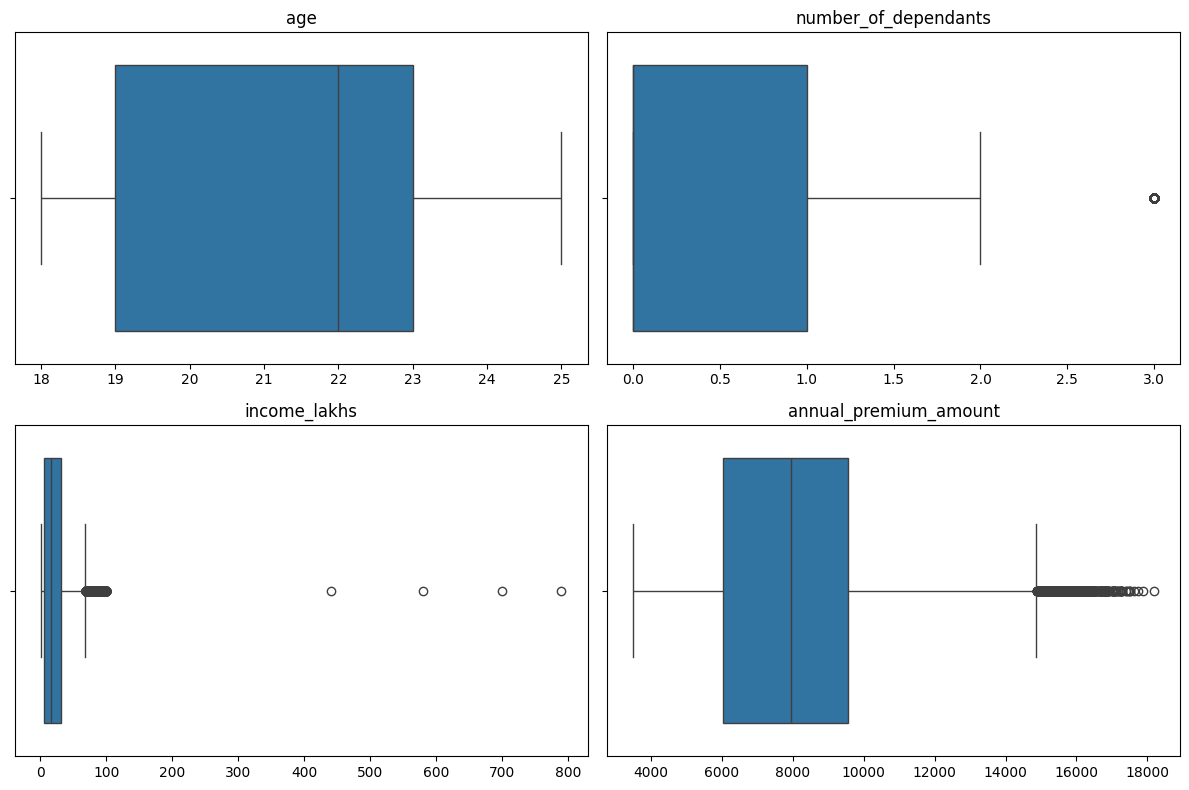

In [91]:

# 2×2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # medium size
axes = axes.flatten()

# Pick first 4 numeric columns (or adjust)
cols_to_plot = numeric_columns[:4]

for ax, col in zip(axes, cols_to_plot):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Hide any empty subplot if less than 4 columns
for ax in axes[len(cols_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Outlier Treatment: Age Column

In [92]:
df[df['age']>100]['age'].unique()

array([], dtype=int64)

In [93]:
df = df[df.age<=100]
df.age.describe()

count    20090.000000
mean        21.494375
std          2.294052
min         18.000000
25%         19.000000
50%         22.000000
75%         23.000000
max         25.000000
Name: age, dtype: float64

### Outlier Treatment: Income Column

In [94]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df['income_lakhs'])
lower, upper

(-31.5, 68.5)

In [95]:
df[df.income_lakhs>upper].shape

(1295, 14)

There are many legitimate records that we will get rid of if we use IQR bounds method. Hence after discussion with business we decided to use a simple quantile bound 

In [96]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [97]:
df[df.income_lakhs>quantile_thresold].shape

(4, 14)

In [98]:
df = df[df.income_lakhs<=quantile_thresold]
df.shape

(20086, 14)

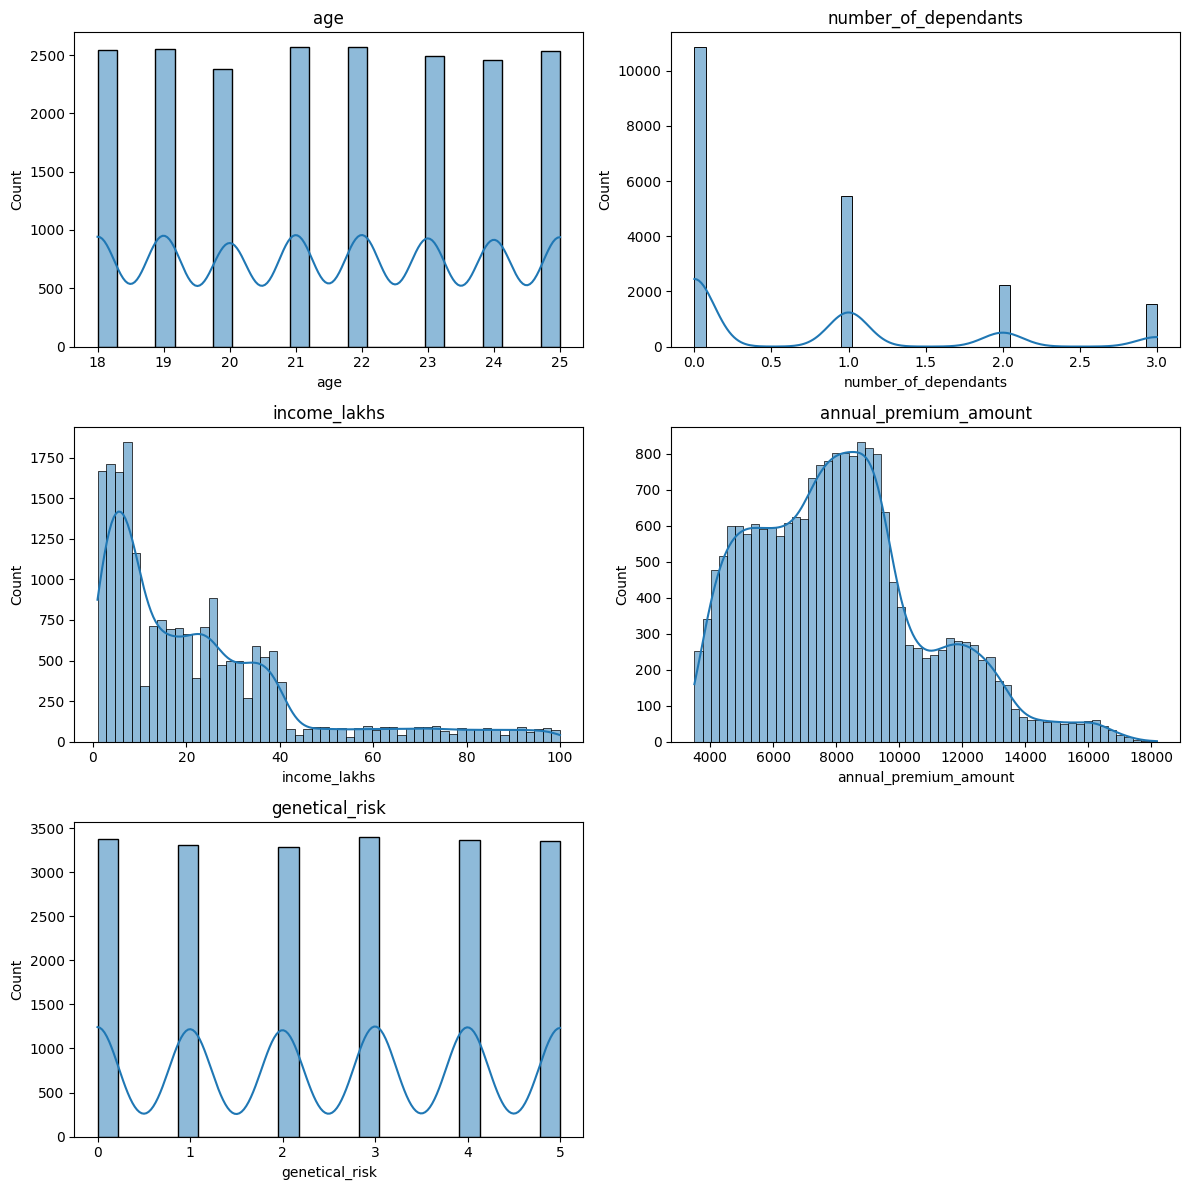

In [99]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))  # 3 rows × 2 cols = 6 slots

axs = axs.flatten()  # flatten to 1-D array for easy indexing

for i, column in enumerate(numeric_columns[:5]):  # only first 5 columns
    sns.histplot(df[column], kde=True, ax=axs[i])
    axs[i].set_title(column)

# Hide any unused subplot(s)
for j in range(5, len(axs)):
    axs[j].axis("off")

plt.tight_layout()
plt.show()


In [100]:
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


### Bivariate Analysis: Numeric Columns

In [101]:
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

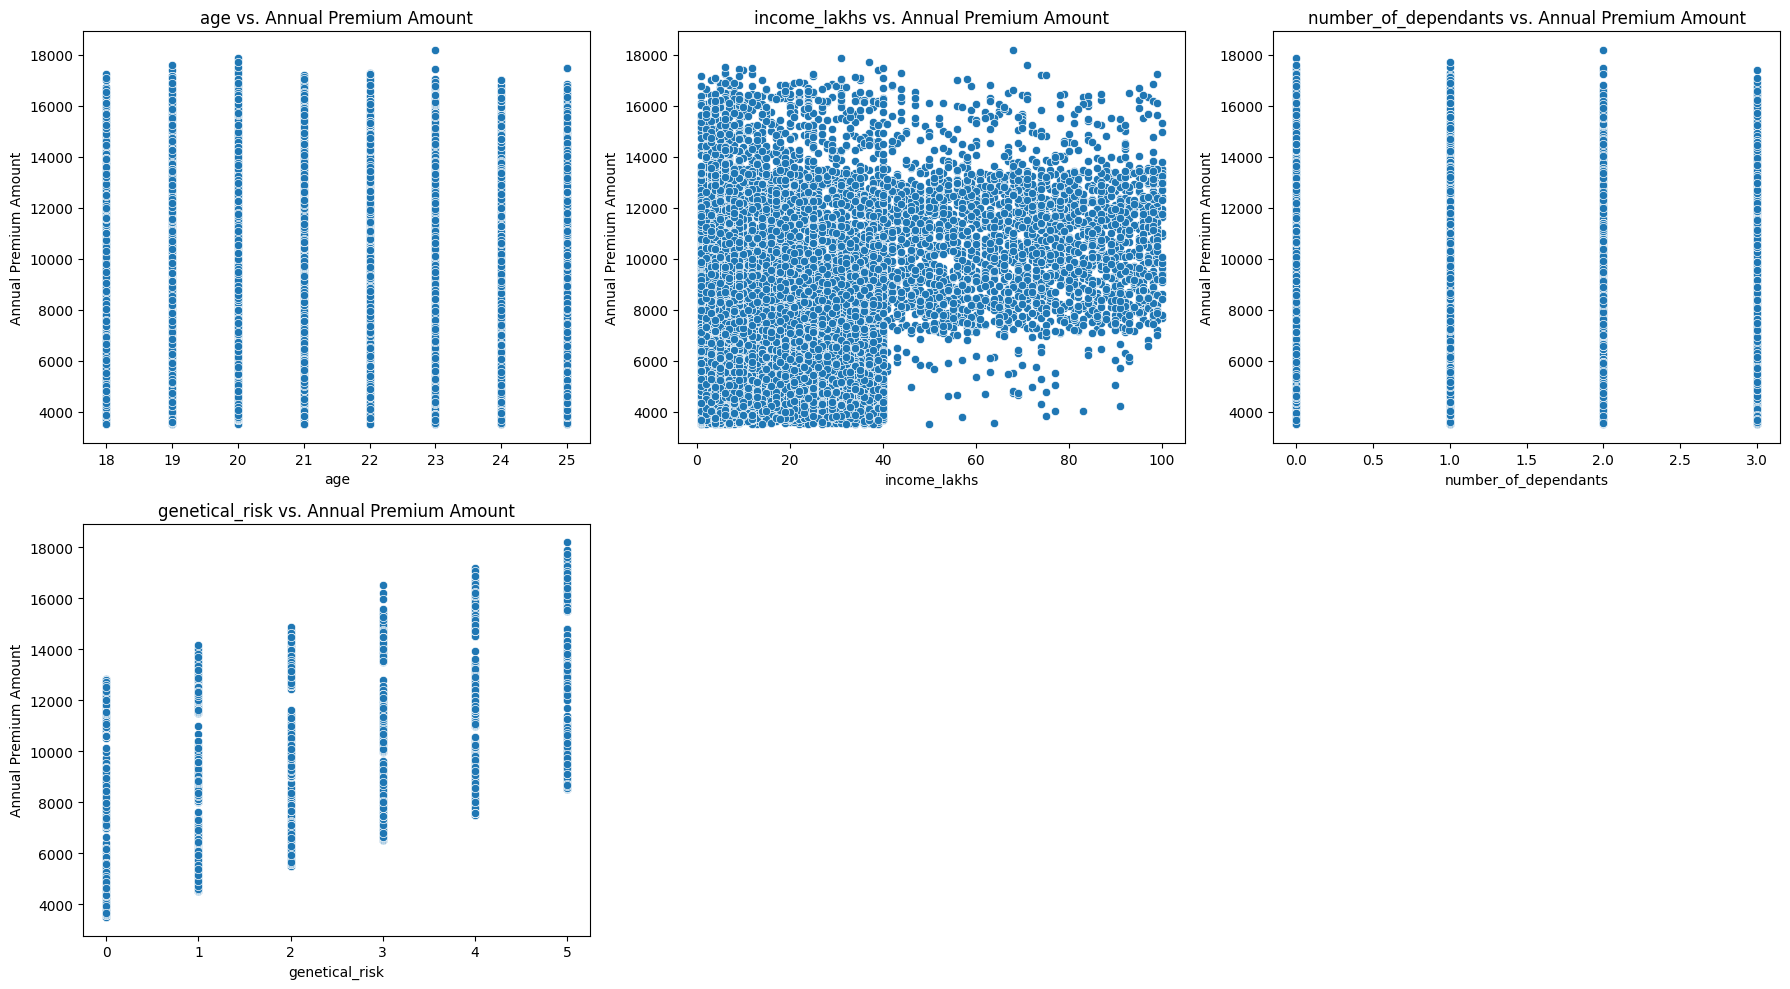

In [102]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants',
                    'genetical_risk']   # example: add a 5th feature

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows × 3 cols = 6 slots
axes = axes.flatten()  # flatten to 1-D array

for ax, column in zip(axes, numeric_features[:5]):  # loop over 5 features
    sns.scatterplot(x=df[column], y=df['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

# Hide any leftover subplot(s)
for j in range(4, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 2. Categorical Columns

In [103]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [104]:
df['smoking_status']= df['smoking_status'].replace({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
})

df['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

### Univariate Analysis

In [105]:
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [106]:
pct_count = df['gender'].value_counts(normalize=True)*100
pct_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

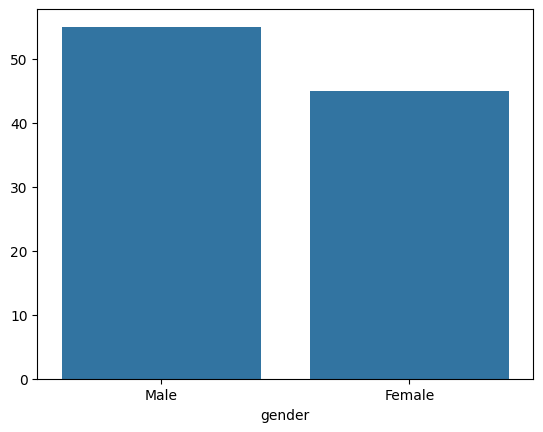

In [107]:
sns.barplot(x=pct_count.index, y=pct_count.values);

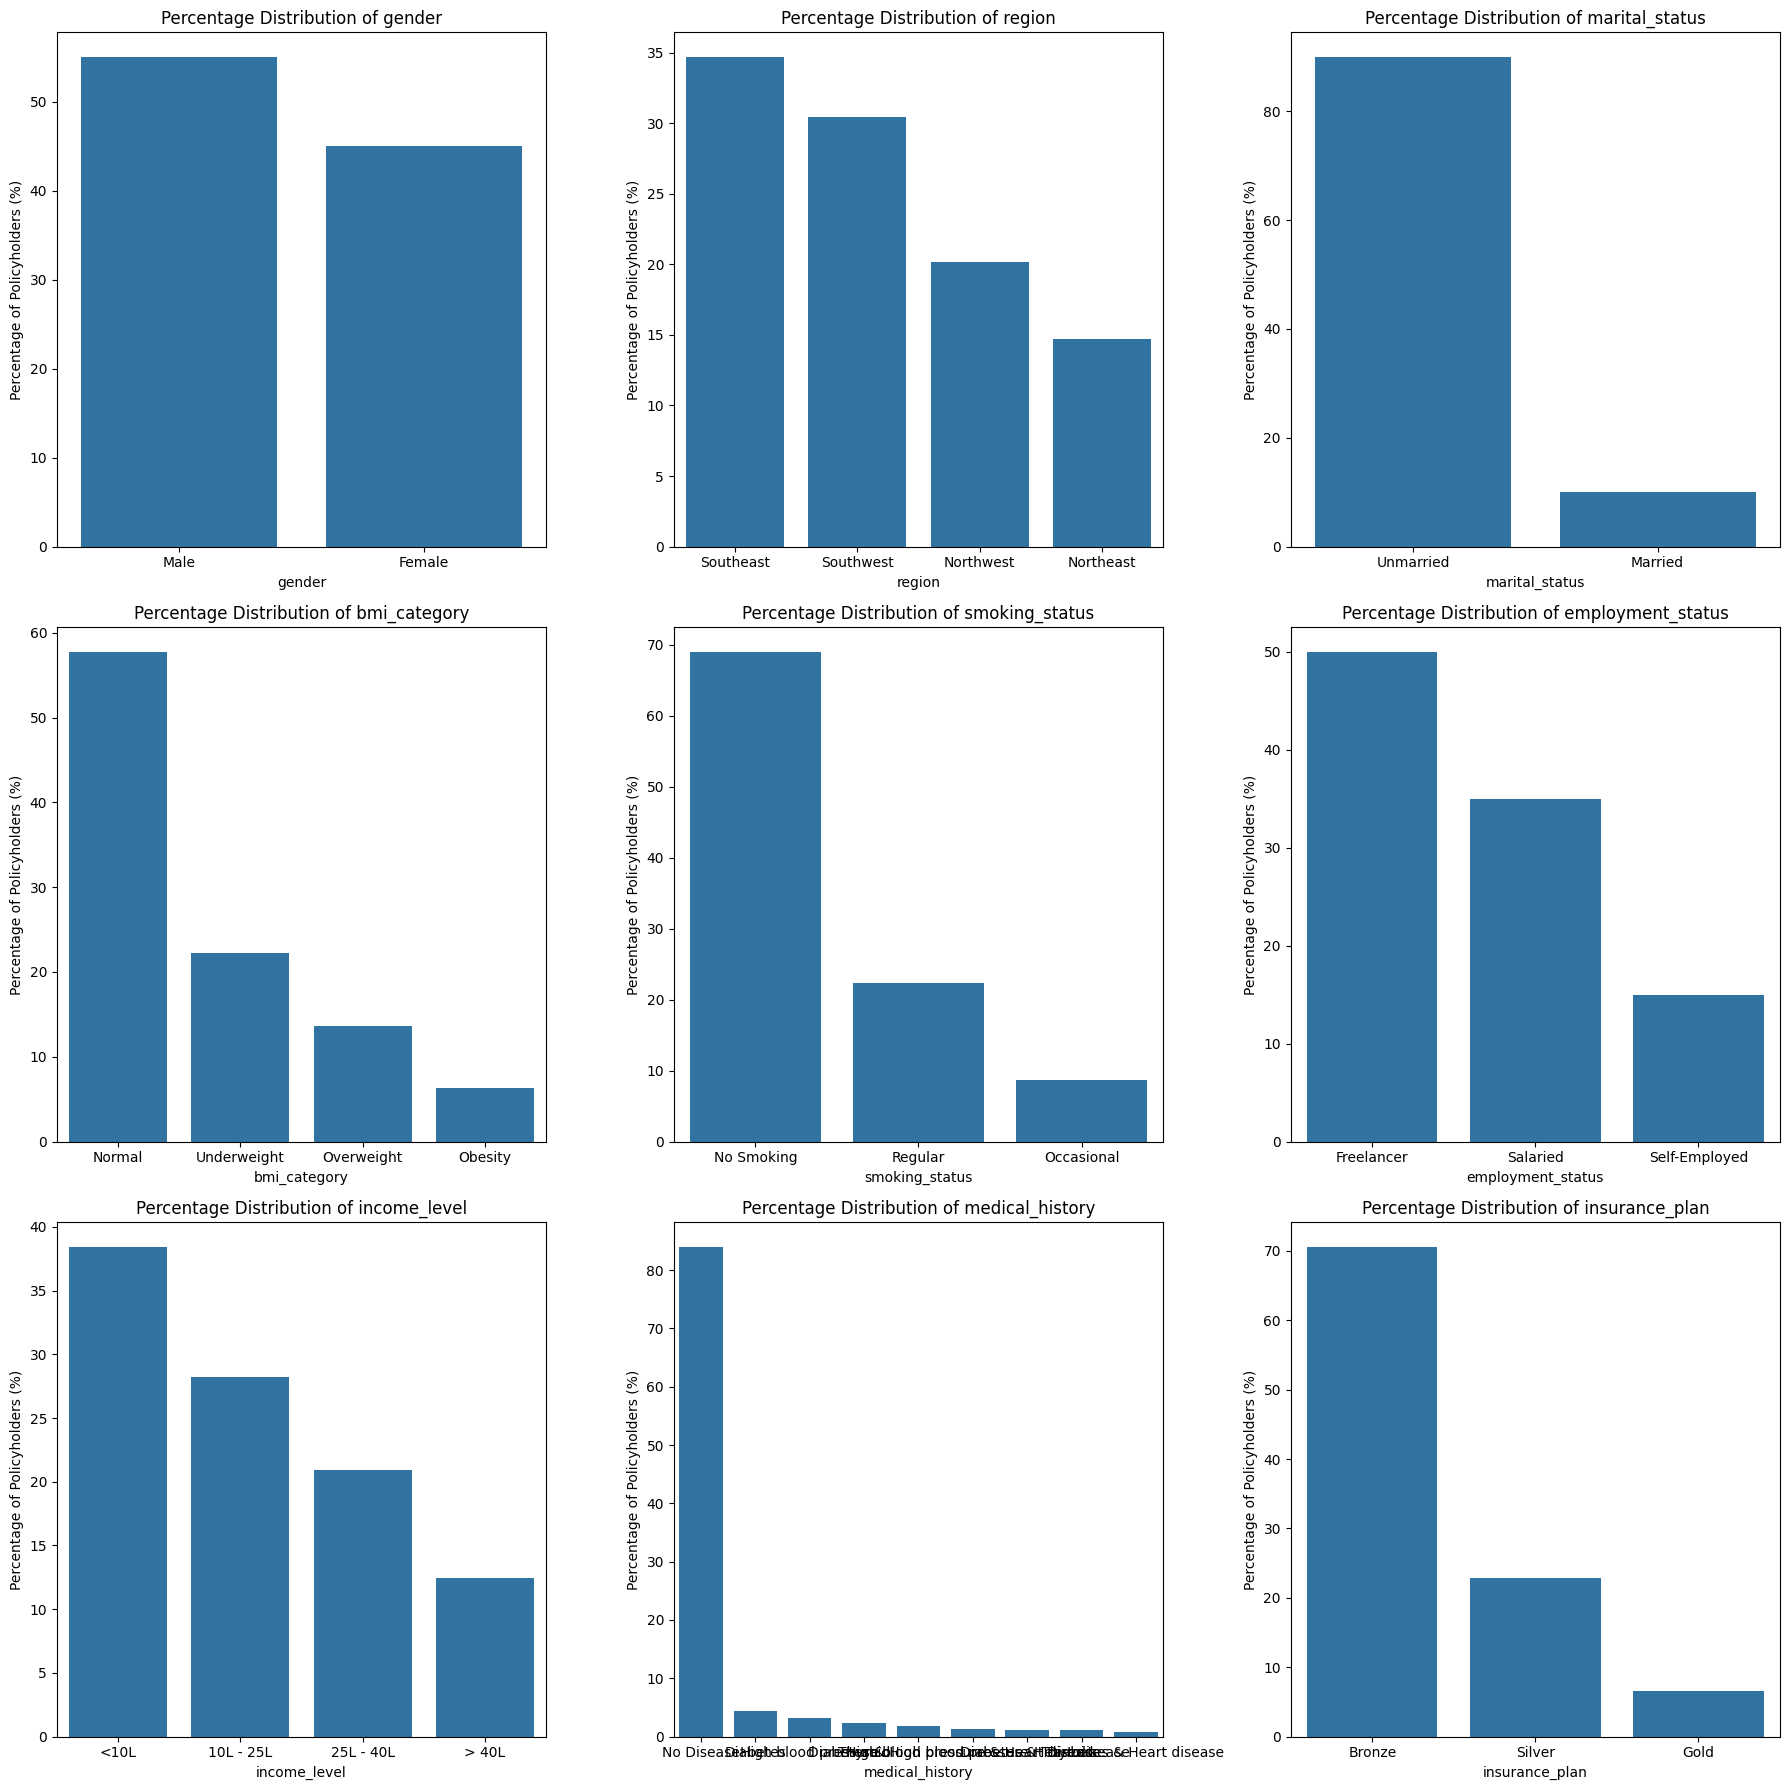

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

### Bivariate Analysis

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


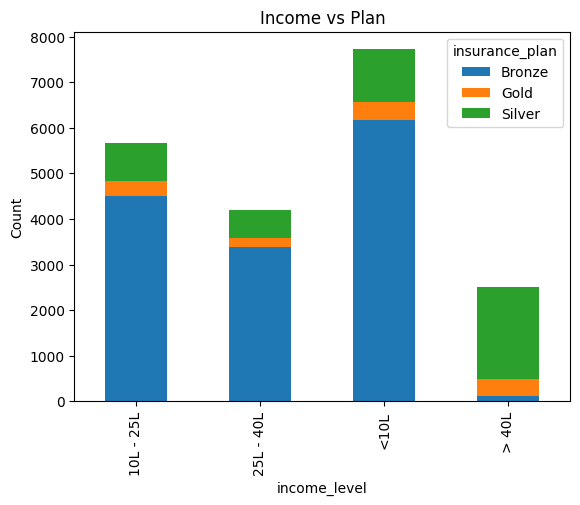

In [109]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

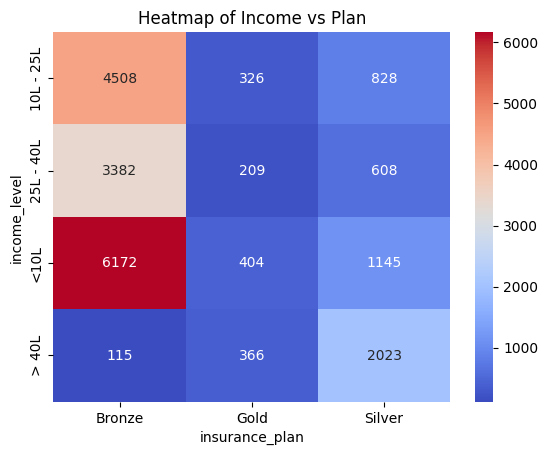

In [110]:
sns.heatmap(crosstab, annot=True, cmap='coolwarm',fmt="d")
plt.title('Heatmap of Income vs Plan')
plt.show()

<h2 align="center" style="color:blue">Feature Engineering</h2>

In [111]:
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


### Calculate Risk Score

In [112]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df[['disease1', 'disease2']] = df['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df['disease1'] = df['disease1'].fillna('none')
df['disease2'] = df['disease2'].fillna('none')
df['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df['total_risk_score'] += df[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df['total_risk_score'].max()
min_score = df['total_risk_score'].min()
df['normalized_risk_score'] = (df['total_risk_score'] - min_score) / (max_score - min_score)
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### Encode Text Columns

In [113]:
#For insurnace plan
#can do label encoding since it is ordinal data

df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

In [114]:
df.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [115]:
#similarly for income_level we do Label encoding
df['income_level'] = df['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

### One Hot Encoding for Nominal Data

In [116]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)
df.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [117]:
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0


### Feature Selection

In [118]:
df = df.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df.head(3)                

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


### Calculate VIF for Multicolinearity

In [119]:
df.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'normalized_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

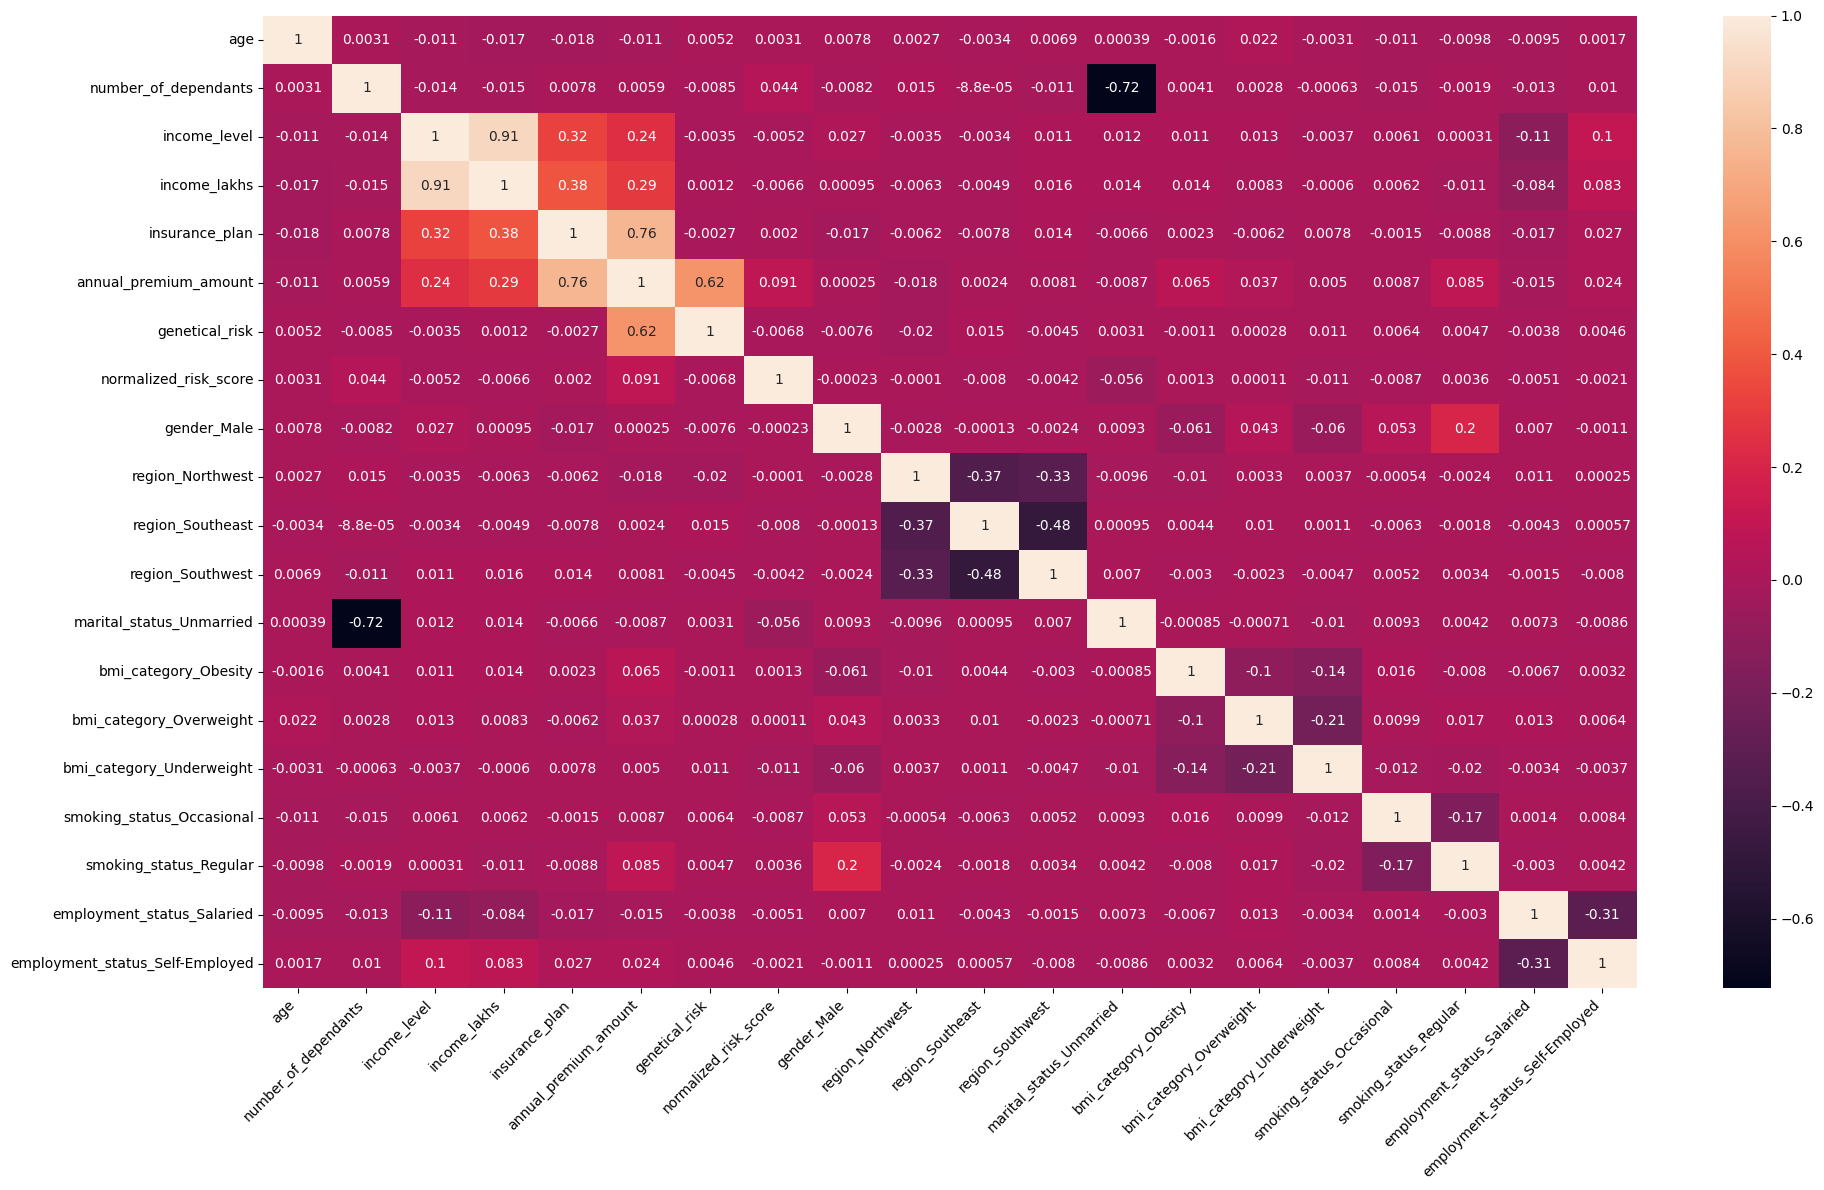

In [120]:
cm = df.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [121]:
X = df.drop('annual_premium_amount', axis='columns')
y = df['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,2.503883,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,1.710184,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [122]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [123]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [124]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [125]:
# we will drop income_lakhs due to high VIF value
X_reduced = X.drop('income_level', axis="columns")

<h2 align="center" style="color:blue">Model Training</h2>

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 18)
x test:  (6026, 18)
y train:  (14060,)
y test:  (6026,)


### Linear Regression Model

In [127]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
train_score, test_score

(0.988297900194864, 0.9887263253056615)

In [128]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  85732.34377930447 RMSE:  292.80086027760314


In [129]:
X_test.shape

(6026, 18)

In [130]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([  -7.229032,   19.536182,   -1.264528, 7001.125261,  999.397746,
       1109.148365,    8.177988,    1.677353,   -3.275327,    6.317095,
         16.068972,  812.844929,  400.375598,  107.529819,  205.069661,
        610.98328 ,    0.038784,   -5.242018])

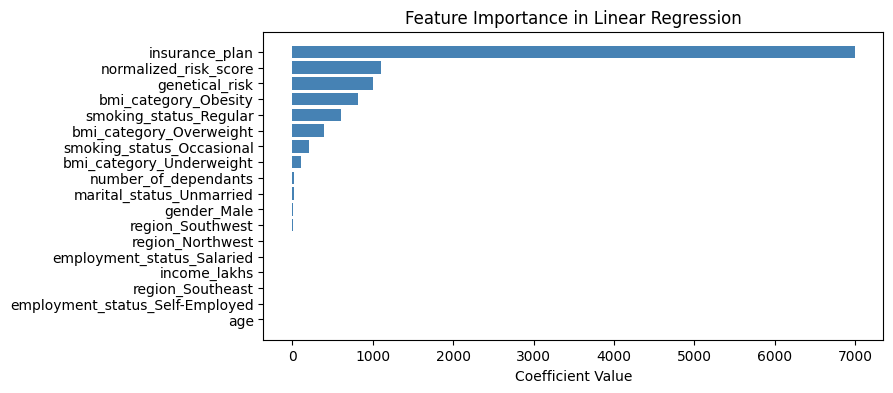

In [131]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression Model

In [132]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.9882974390415337, 0.9887266341700511)

In [133]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  85729.99497390221 RMSE:  292.79684932372857


### XGBoost 

In [134]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)

0.9876989126205444

In [135]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  93545.5234375 RMSE:  305.85212675000315


In [136]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9879226088523865)

In [137]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [138]:
best_model = random_search.best_estimator_

### Error Analysis

In [139]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals * 100) / y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

results_df

,actual,predicted,diff,diff_pct
12774,6238,6104.117676,-133.882324,-2.146238
14758,9462,9593.652344,131.652344,1.391380
13205,5152,5619.506348,467.506348,9.074269
14278,6988,7377.886230,389.886230,5.579368
19351,4917,5109.857422,192.857422,3.922258
...,...,...,...,...
17652,7635,8060.910645,425.910645,5.578397
5807,4845,4650.275879,-194.724121,-4.019074
10298,13866,13273.239258,-592.760742,-4.274922
13316,5255,5109.857422,-145.142578,-2.761990


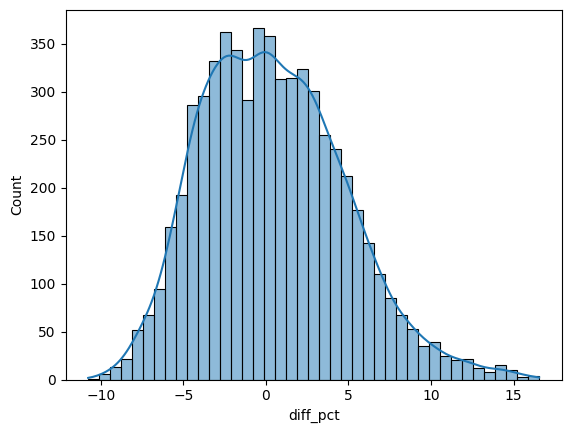

In [140]:
sns.histplot(results_df['diff_pct'], kde= True);

In [141]:
extreme_error_threshold = 10 # You can adjust this threshold based on your domain knowledge or requirements
extreme_result_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_result_df.shape

(150, 4)

In [142]:
results_df.shape

(6026, 4)

In [143]:
extreme_error_pct = (extreme_result_df.shape[0] * 100) / results_df.shape[0]
extreme_error_pct

2.489213408562894

We have very few extreme errors (only 0.3%) which means this model looks good and no further investigation is required

### Export the Model

In [148]:
from joblib import dump

dump(best_model, "artifacts/model_young.joblib")

scaler_with_col = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_col, "artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']

In [147]:
scaler_with_col = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

scaler_with_col

{'scaler': MinMaxScaler(),
 'cols_to_scale': ['age',
  'number_of_dependants',
  'income_level',
  'income_lakhs',
  'insurance_plan']}